# Relationship between roads and LULC classes

- Load road network and lulc files
- Buffer road network
- Intersect LULC with roads
- Calculate pivot tables per speed limit classes and LULC classes
- Plot tables to show relationship
- Calculate Pearson and Spearman Correlation matrix between LULC classes

In [46]:
import requests
import sys
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import pearsonr

crs = 25832
country_iso = 'DE'

sns.set_theme(style='ticks')
sns.set_context('paper')

plt.rcParams['font.size'] = 12  # Adjust base font size as needed
plt.rcParams['axes.labelsize'] = 12  # For x and y labels
plt.rcParams['axes.titlesize'] = 12  # For subplot titles
plt.rcParams['xtick.labelsize'] = 12  # For x-axis tick labels
plt.rcParams['ytick.labelsize'] = 12  # For y-axis tick labels

data_dir = Path('../data')
out_dir = Path('../outdir')

In [2]:
cmap_diverging = 'BrBG'
colors = plt.get_cmap(cmap_diverging)(np.linspace(0.5, 1.0,  plt.get_cmap(cmap_diverging).N // 2))
cmap_sequential = LinearSegmentedColormap.from_list('my_sequential', colors)

In [3]:
road_network = gpd.read_feather(out_dir / 'preprocessed_road_network.feather')
lulc_union = gpd.read_feather(out_dir / 'preprocessed_lulc_union.feather')

## Preprocess data

Speeds

In [3]:
speed_cols = ['zone:maxspeed', 'zone:traffic', 'maxspeed:type', 'source:maxspeed', 'maxspeed']

speed_zone_types = ['living_street', 'urban', 'rural', 'trunk', 'motorway']

speed_limit_classes = {
    "class_bounds": [1, 10, 30, 50, 70, 90, 110, 130, 255],
    "class_labels": ['walk', 'very_low', 'low', 'medium', 'high', 'very_high', 'very_high+', 'unlimited']
}

In [4]:
# Query OSM speed data
speeds_request = requests.get(
    r'https://raw.githubusercontent.com/GIScience/openrouteservice/master/ors-engine/src/main/resources/resources/services/routing/speed_limits/car.json'
)
if speeds_request.status_code == 200:  # Status == OK
    hwy_speeds = speeds_request.json()
    country_speeds = hwy_speeds['max_speeds']
    default_speeds = hwy_speeds['default']
else:
    print(f'Error when requesting ORS for speed limits: {speeds_request.status_code}')
    sys.exit()

# Create speed type mapping dictionary
speed_zone_types_mapping = {
    **{f'{key}': country_speeds.get(f'{country_iso}:{key}', default_speeds.get(key)) for key in speed_zone_types},
    'walk': country_speeds.get(f'{country_iso}:living_street', default_speeds.get('living_street')),
    'variable': np.nan,
    # none != Nan, so set to 255 as 'unlimited'
    'none': 255,
}

In [6]:
def feature_engineer_maxspeeds(road_network: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """This class method feature engineers the maxspeed column by applying manual MVI and casting to integers."""
    # Remove all occurrences of 'sign'
    road_network = road_network.replace('sign', np.nan, regex=False)

    # Enrich source:maxspeed by merging other columns
    for column in speed_cols:
        # Create col if it doesn't exist
        road_network[column] = road_network[column] if column in road_network.columns else np.nan
        # Add vales from col to source:maxspeed
        if road_network['source:maxspeed'].isna().any():
            road_network['source:maxspeed'] = road_network['source:maxspeed'].fillna(road_network[column])

    road_network = __cleanup_speed_column(road_network, 'source:maxspeed', speed_zone_types_mapping)
    road_network = __cleanup_speed_column(road_network, 'maxspeed', speed_zone_types_mapping)

    # Replace values in maxspeed with mapping_dict
    road_network['maxspeed'] = road_network['maxspeed'].replace(speed_zone_types_mapping)
    # Replace values in source:maxspeed only when maxspeed is Nan (if maxspeed exists, MVI not necessary)
    road_network.loc[road_network['maxspeed'].isna(), 'source:maxspeed'] = road_network['source:maxspeed'].replace(speed_zone_types_mapping)
    # Fill Nans in maxspeed with enriched source:maxspeed, fill remaining Nans with zeros
    road_network['maxspeed'] = road_network['maxspeed'].fillna(road_network['source:maxspeed']).fillna(0)

    def assign_maxspeeds_from_file(row):
        # Create adapted mapping dictionary using the speed file and highway type
        file_mapping_dict = {
            **{key: country_speeds.get(f'{country_iso}:{key}', default_speeds.get(row['highway'])) for key in speed_zone_types_mapping.keys()},
            # Check if highway type in default speeds, else set to 0
            'default': default_speeds.get(row['highway'], 0)
        }

        return file_mapping_dict.get(row['maxspeed'], row['maxspeed'])

    # Get speed values for speed type maxspeeds
    road_network['maxspeed'] = road_network.apply(assign_maxspeeds_from_file, axis=1)
    # Convert maxspeed values to integers
    road_network['maxspeed'] = road_network['maxspeed'].astype(int)

    # Return road network with feature engineered maxspeed, drop used cols except last one (maxspeed)
    return road_network.drop(columns=speed_cols[:-1], errors='ignore')

def categorize_speed_limits(road_network: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """This class method categorizes the speed limits of the road network."""
    road_network['speed_limit_class'] = (
        pd.cut(
            road_network['maxspeed'],
            bins=speed_limit_classes['class_bounds'],
            labels=speed_limit_classes['class_labels'],
            include_lowest=True,
            ordered=True
        )
    )
    # Drop all roads without assigned speed limit class
    road_network.dropna(subset=['speed_limit_class'], inplace=True)
    # Convert categorical col to strings (for OHE)
    road_network['speed_limit_class'] = road_network['speed_limit_class'].astype(str)

    return road_network


@staticmethod
def __cleanup_speed_column(df, column_name, mapping_dict):
    df[column_name] = (
        df[column_name]
        # Remove everything before ':' including (e.g. DE:zone30 -> zone30)
        .str.replace('^.*?:', '', regex=True)
        # Remove all occurrences of 'zone' (e.g. zone30 -> 30)
        .str.replace('zone', '', regex=False)
        # If remaining values are empty strings, convert them to Nan
        .replace('', np.nan)
    )
    # Check remains: if one of the conditions is True, keep value
    df[column_name] = df[column_name].where(
        # If value is Nan
        df[column_name].isna() |
        # If value is in speed_zone_types_mapping keys
        df[column_name].isin(mapping_dict.keys()) |
        # If value is a digit
        df[column_name].str.isdigit() |
        # Default values get assigned later on (special case)
        (df[column_name] == 'default')
    )
    return df

In [7]:
road_network = feature_engineer_maxspeeds(road_network)
road_network = categorize_speed_limits(road_network)

road_network['speed_limit_class'].value_counts(dropna=False).sort_values()

speed_limit_class
high             72
unlimited       437
very_high+      559
walk           1194
very_high      1387
medium         2355
low            9699
very_low      16701
Name: count, dtype: int64

Reproject

In [8]:
road_network.to_crs(crs, inplace=True)
lulc_union.to_crs(crs, inplace=True)

Calculate road lengths

In [9]:
road_network['road_length'] = round(road_network['geometry'].length, 2)

In [10]:
f'{round(road_network["road_length"].sum() / 1000, 2)} km'

'4231.83 km'

Add colormap to LULC

In [11]:
colors = {
    'built-up': '#ff0000',
    'farmland': '#ffff50',
    'forest': '#4dc800',
    'grass': '#cdebb0',
    'permanent_crops': '#e68000',
    'water': '#82c8fa'
}

lulc_union['color'] = lulc_union['lulc'].map(colors)

Buffer road network

In [12]:
road_network_10 = road_network.copy()
road_network_10['geometry'] = road_network_10['geometry'].buffer(10)
road_network_25 = road_network.copy()
road_network_25['geometry'] = road_network_25['geometry'].buffer(25)

## Statistical relationship: intersect LULC classes by road network and compare lengths and proportions

### Preprocess calculations

Intersect road network with LULC (takes longer, > 30 mins)

In [13]:
lulc_roads = gpd.sjoin(road_network, lulc_union, how="inner", predicate="intersects")
lulc_roads_10 = gpd.sjoin(road_network_10, lulc_union, how="inner", predicate="intersects")
lulc_roads_25 = gpd.sjoin(road_network_25, lulc_union, how="inner", predicate="intersects")

Save intersected road files as feather and load again

In [ ]:
lulc_roads.to_feather(out_dir / 'lulc_road_speeds.feather')
lulc_roads_10.to_feather(out_dir / 'lulc_road_speeds_10.feather')
lulc_roads_25.to_feather(out_dir / 'lulc_road_speeds_25.feather')

In [5]:
lulc_roads = gpd.read_feather(out_dir / 'lulc_road_speeds.feather')
lulc_roads_10 = gpd.read_feather(out_dir / 'lulc_road_speeds_10.feather')
lulc_roads_25 = gpd.read_feather(out_dir / 'lulc_road_speeds_25.feather')

Calculate total road length for each LULC class

In [6]:
road_length_by_lulc = lulc_roads.groupby('lulc')['road_length'].sum()
road_length_by_lulc_10 = lulc_roads_10.groupby('lulc')['road_length'].sum()
road_length_by_lulc_25 = lulc_roads_25.groupby('lulc')['road_length'].sum()

In [7]:
round(road_length_by_lulc.unique().sum() / 1000, 2), round(road_length_by_lulc_10.unique().sum() / 1000, 2), round(road_length_by_lulc_25.unique().sum() / 1000, 2)

(3331.71, 6209.52, 7736.59)

Aggregate total road lengths by speed limit class for each LULC class

In [8]:
lulc_pivot = lulc_roads.pivot_table(index='speed_limit_class', columns='lulc', values='road_length', aggfunc='sum', fill_value=0)
lulc_pivot_10 = lulc_roads_10.pivot_table(index='speed_limit_class', columns='lulc', values='road_length', aggfunc='sum', fill_value=0)
lulc_pivot_25 = lulc_roads_25.pivot_table(index='speed_limit_class', columns='lulc', values='road_length', aggfunc='sum', fill_value=0)

### Speed Limit Classess per LULC Classes

Proportion of each speed limit class per LULC class (Vertical 100 %)

In [26]:
lulc_pivot_percent_lulc = lulc_pivot.divide(lulc_pivot.sum(axis=0), axis=1) * 100
lulc_pivot_percent_lulc_10 = lulc_pivot_10.divide(lulc_pivot_10.sum(axis=0), axis=1) * 100
lulc_pivot_percent_lulc_25 = lulc_pivot_25.divide(lulc_pivot_25.sum(axis=0), axis=1) * 100

# Reindex with speed_limit_class labels (based on buffer 25)
filtered_draw_order_v = [index for index in speed_limit_classes['class_labels'] if index in lulc_pivot_percent_lulc_25.index]
lulc_pivot_percent_lulc = lulc_pivot_percent_lulc.reindex(filtered_draw_order_v)
lulc_pivot_percent_lulc_10 = lulc_pivot_percent_lulc_10.reindex(filtered_draw_order_v)
lulc_pivot_percent_lulc_25 = lulc_pivot_percent_lulc_25.reindex(filtered_draw_order_v)

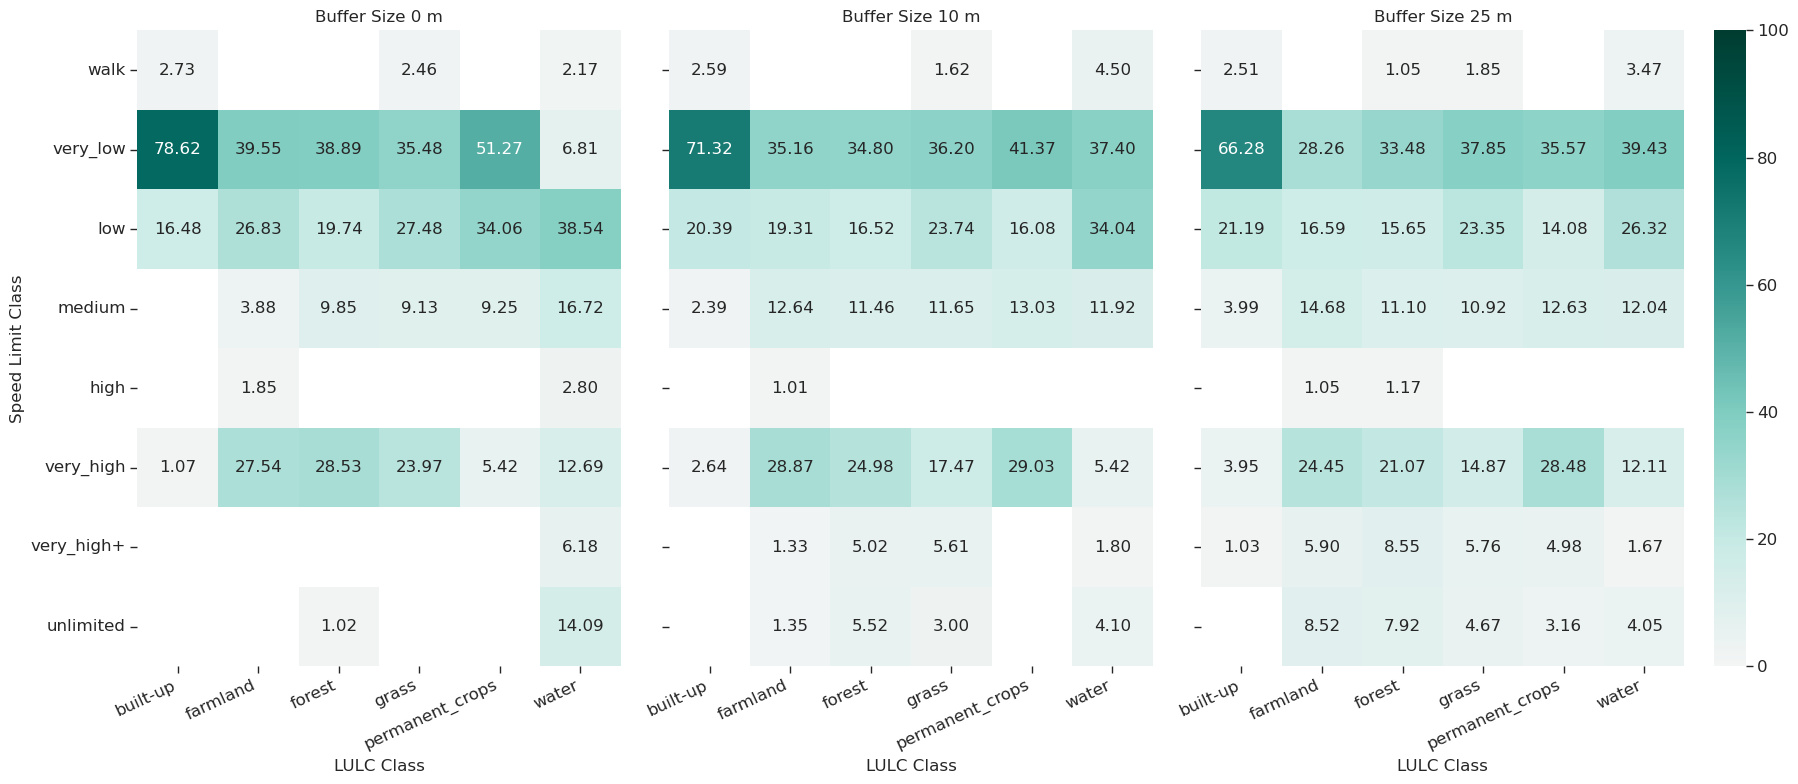

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(18, 8), sharey=True)

vmin=0
vmax=100

mask_roads = lulc_pivot_percent_lulc < 1
mask_roads_10 = lulc_pivot_percent_lulc_10 < 1
mask_roads_25 = lulc_pivot_percent_lulc_25 < 1

sns.heatmap(lulc_pivot_percent_lulc, mask=mask_roads, cmap=cmap_sequential, annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar=False, ax=axs[0])
axs[0].set_title('Buffer Size 0 m')
axs[0].set_ylabel('Speed Limit Class')
axs[0].set_yticklabels(axs[0].get_yticklabels(), rotation=0)
axs[0].set_xlabel('LULC Class')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=25, ha='right')

sns.heatmap(lulc_pivot_percent_lulc_10, mask=mask_roads_10, cmap=cmap_sequential, annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar=False, ax=axs[1])
axs[1].set_title('Buffer Size 10 m')
axs[1].set_ylabel('')
axs[1].set_xlabel('LULC Class')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=25, ha='right')

sns.heatmap(lulc_pivot_percent_lulc_25, mask=mask_roads_25, cmap=cmap_sequential, annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar_kws={'pad': -0.15, 'anchor': (2.5, 0.5)}, ax=axs[2])
axs[2].set_title('Buffer Size 25 m')
axs[2].set_ylabel('')
axs[2].set_xlabel('LULC Class')
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=25, ha='right')

# plt.savefig(out_dir / 'speeds_lulc_vertical.png', dpi=150, bbox_inches='tight')

plt.tight_layout()
plt.show()

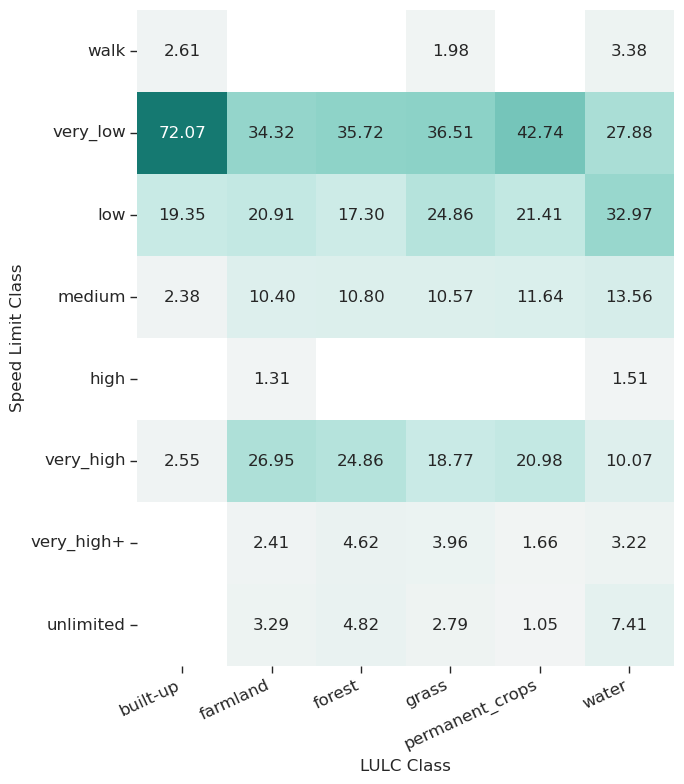

In [45]:
lulc_pivot_percent_lulc_mean = (lulc_pivot_percent_lulc + lulc_pivot_percent_lulc_10 + lulc_pivot_percent_lulc_25) / 3

fig, ax = plt.subplots(figsize=(7, 8))

mask_roads_mean = lulc_pivot_percent_lulc_mean < 1

sns.heatmap(lulc_pivot_percent_lulc_mean, mask=mask_roads_mean, cmap=cmap_sequential, annot=True, fmt='.2f', vmin=0, vmax=100, cbar=False, ax=ax)
ax.set_ylabel('Speed Limit Class')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_xlabel('LULC Class')
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')

plt.tight_layout()
plt.show()

Calculate differences between buffer sizes

In [29]:
diff_0_to_10_lulc = lulc_pivot_percent_lulc_10 - lulc_pivot_percent_lulc
diff_10_to_25_lulc = lulc_pivot_percent_lulc_25- lulc_pivot_percent_lulc_10
diff_0_to_25_lulc = lulc_pivot_percent_lulc_25 - lulc_pivot_percent_lulc

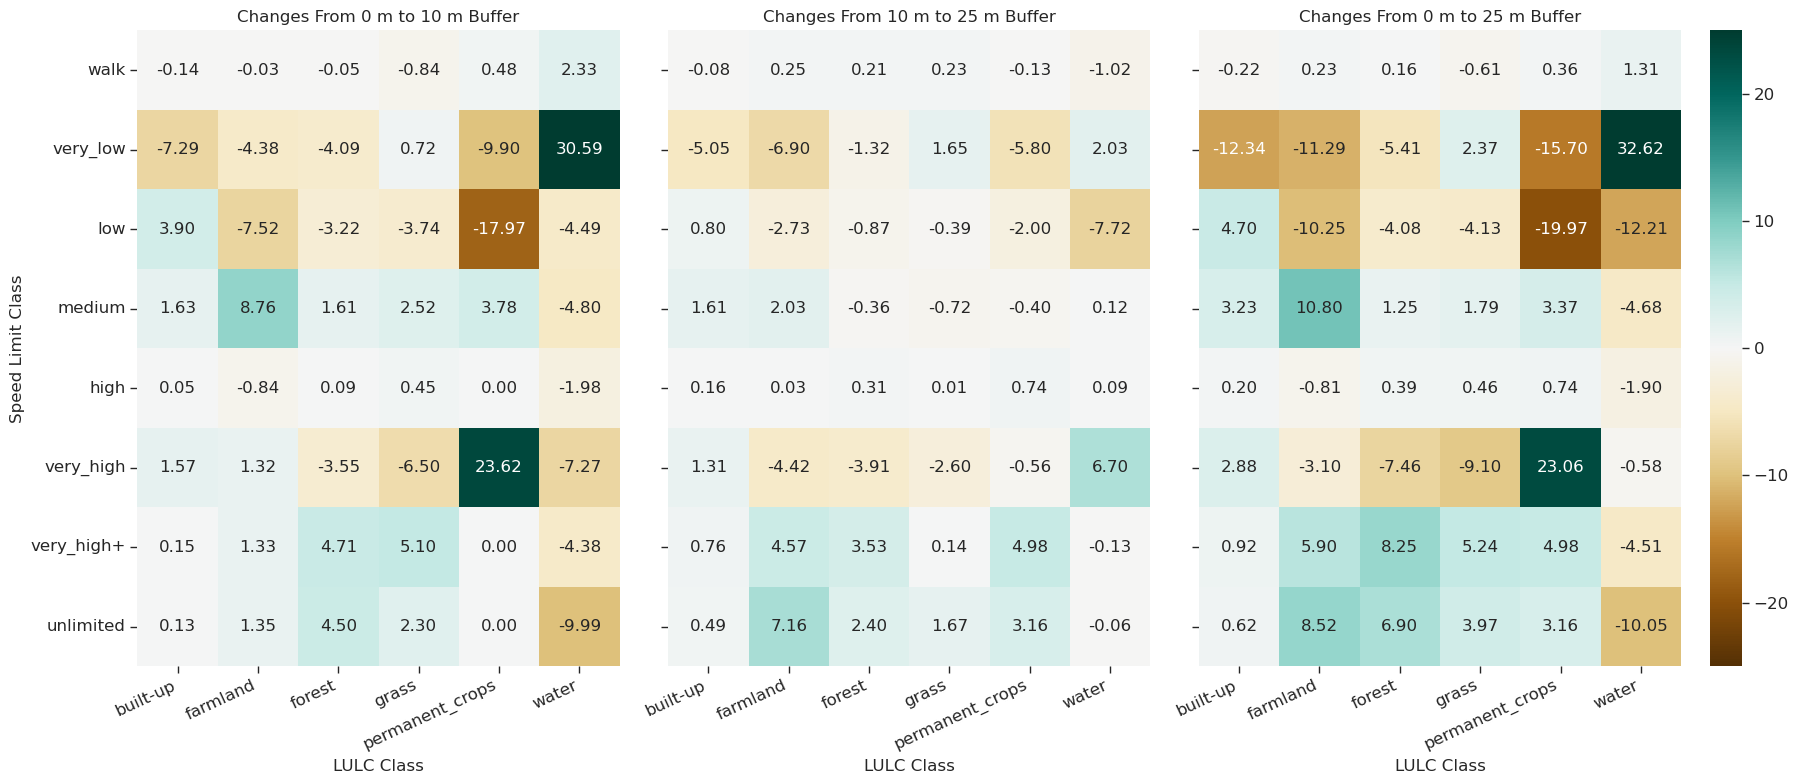

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(18, 8), sharey=True)

vmin=-25
vmax=25

# Difference from 0m to 10m
sns.heatmap(diff_0_to_10_lulc, cmap=cmap_diverging, annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar=False, ax=axs[0])
axs[0].set_title('Changes From 0 m to 10 m Buffer')
axs[0].set_ylabel('Speed Limit Class')
axs[0].set_yticklabels(axs[0].get_yticklabels(), rotation=0)
axs[0].set_xlabel('LULC Class')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=25, ha='right')

# Difference from 10m to 25m
sns.heatmap(diff_10_to_25_lulc, cmap=cmap_diverging, annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar=False, ax=axs[1])
axs[1].set_title('Changes From 10 m to 25 m Buffer')
axs[1].set_ylabel('')
axs[1].set_xlabel('LULC Class')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=25, ha='right')

# Difference from 0m to 25m
sns.heatmap(diff_0_to_25_lulc, cmap=cmap_diverging, annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar_kws={'pad': -0.15, 'anchor': (2.5, 0.5)}, ax=axs[2])
axs[2].set_title('Changes From 0 m to 25 m Buffer')
axs[2].set_ylabel('')
axs[2].set_xlabel('LULC Class')
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=25, ha='right')

# plt.savefig(out_dir / 'speeds_lulc_vertical_changes.png', dpi=150, bbox_inches='tight')

plt.tight_layout()
plt.show()

### LULC Classes per Speed Limit Classes

Proportion of a speed limit class belonging to each LULC class (Horizontal 100 %)

In [31]:
lulc_pivot_percent_speeds = lulc_pivot.divide(lulc_pivot.sum(axis=1), axis=0) * 100
lulc_pivot_percent_speeds_10 = lulc_pivot_10.divide(lulc_pivot_10.sum(axis=1), axis=0) * 100
lulc_pivot_percent_speeds_25 = lulc_pivot_25.divide(lulc_pivot_25.sum(axis=1), axis=0) * 100

# Reindex with speed_limit_class labels (based on buffer 25)
filtered_draw_order_h = [index for index in speed_limit_classes['class_labels'] if index in lulc_pivot_percent_speeds_25.index]
lulc_pivot_percent_speeds = lulc_pivot_percent_speeds.reindex(filtered_draw_order_h)
lulc_pivot_percent_speeds_10 = lulc_pivot_percent_speeds_10.reindex(filtered_draw_order_h)
lulc_pivot_percent_speeds_25 = lulc_pivot_percent_speeds_25.reindex(filtered_draw_order_h)

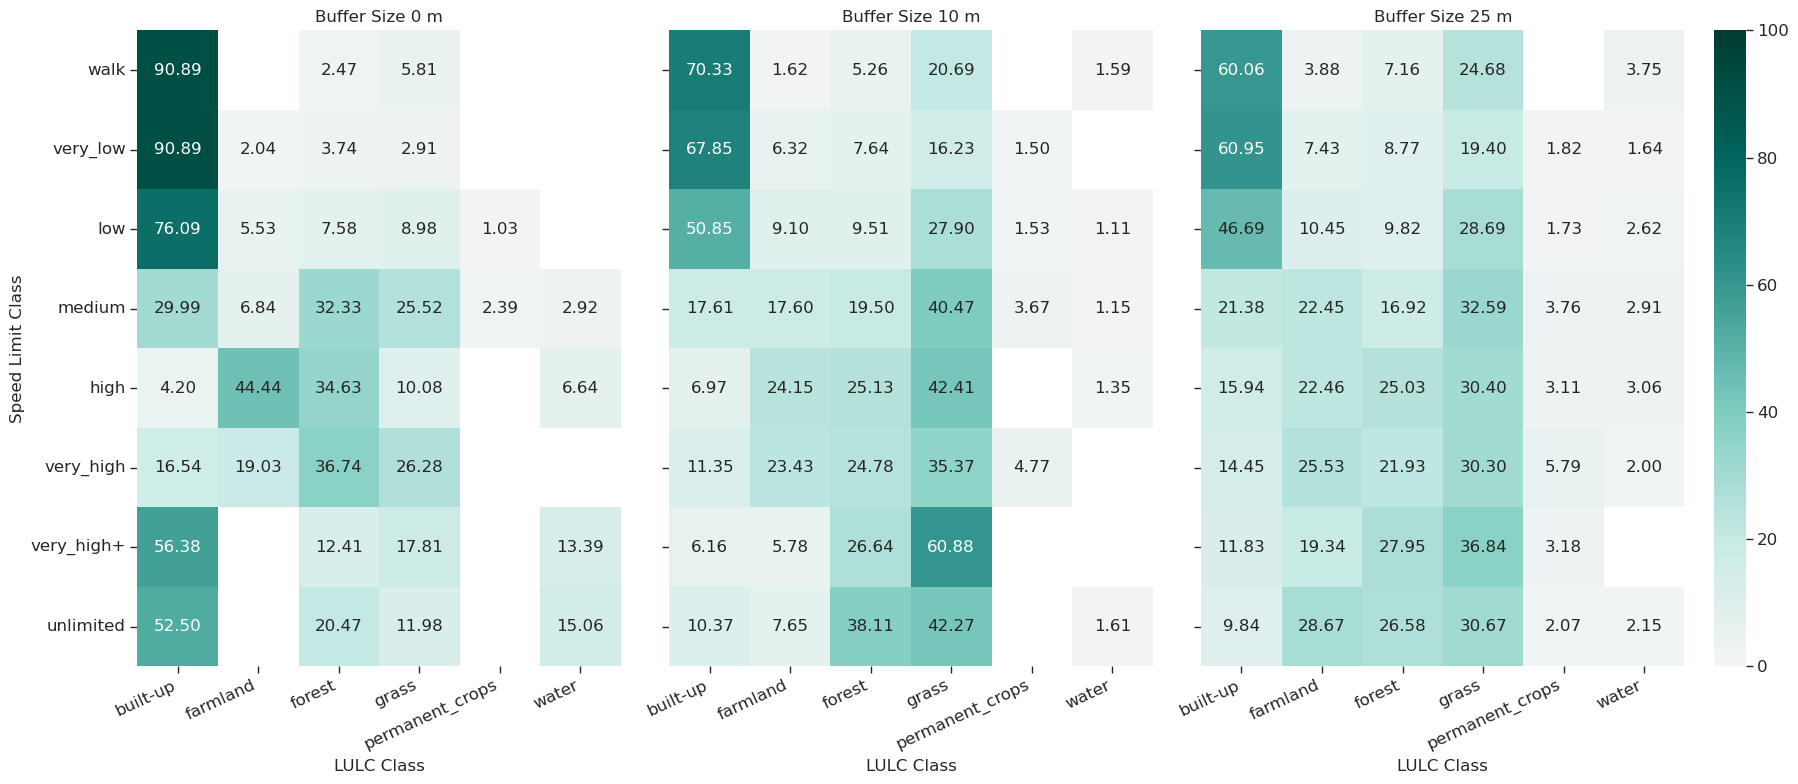

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(18, 8), sharey=True)

vmin=0
vmax=100

mask_speeds = lulc_pivot_percent_speeds < 1
mask_speeds_10 = lulc_pivot_percent_speeds_10 < 1
mask_speeds_25 = lulc_pivot_percent_speeds_25 < 1

sns.heatmap(lulc_pivot_percent_speeds, mask=mask_speeds, cmap=cmap_sequential, annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar=False, ax=axs[0])
axs[0].set_title('Buffer Size 0 m')
axs[0].set_ylabel('Speed Limit Class')
axs[0].set_yticklabels(axs[0].get_yticklabels(), rotation=0)
axs[0].set_xlabel('LULC Class')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=25, ha='right')

sns.heatmap(lulc_pivot_percent_speeds_10, mask=mask_speeds_10, cmap=cmap_sequential, annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar=False, ax=axs[1])
axs[1].set_title('Buffer Size 10 m')
axs[1].set_ylabel('')
axs[1].set_xlabel('LULC Class')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=25, ha='right')

sns.heatmap(lulc_pivot_percent_speeds_25, mask=mask_speeds_25, cmap=cmap_sequential, annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar_kws={'pad': -0.15, 'anchor': (2.5, 0.5)}, ax=axs[2])
axs[2].set_title('Buffer Size 25 m')
axs[2].set_ylabel('')
axs[2].set_xlabel('LULC Class')
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=25, ha='right')

# plt.savefig(out_dir / 'speeds_lulc_horizontal.png', dpi=150, bbox_inches='tight')

plt.tight_layout()
plt.show()

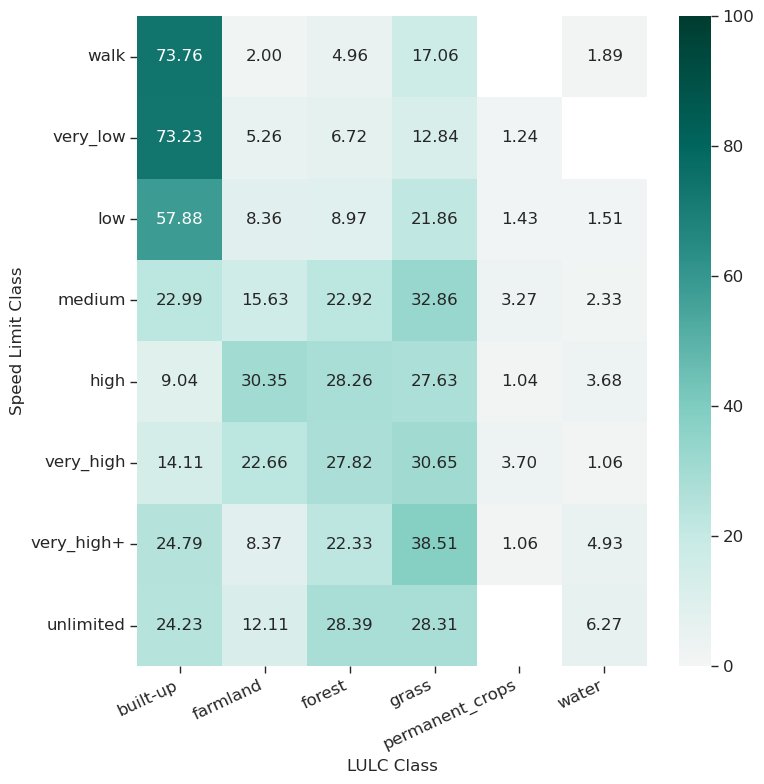

In [44]:
lulc_pivot_percent_speeds_mean = (lulc_pivot_percent_speeds + lulc_pivot_percent_speeds_10 + lulc_pivot_percent_speeds_25) / 3

fig, ax = plt.subplots(figsize=(8, 8))

mask_speeds_mean = lulc_pivot_percent_speeds_mean < 1

sns.heatmap(lulc_pivot_percent_speeds_mean, mask=mask_speeds_mean, cmap=cmap_sequential, annot=True, fmt='.2f', vmin=0, vmax=100, cbar=True, ax=ax)
ax.set_ylabel('Speed Limit Class')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_xlabel('LULC Class')
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')

plt.tight_layout()
plt.show()

Calculate differences between buffer sizes

In [34]:
diff_0_to_10_speeds = lulc_pivot_percent_speeds_10 - lulc_pivot_percent_speeds
diff_10_to_25_speeds = lulc_pivot_percent_speeds_25- lulc_pivot_percent_speeds_10
diff_0_to_25_speeds = lulc_pivot_percent_speeds_25 - lulc_pivot_percent_speeds

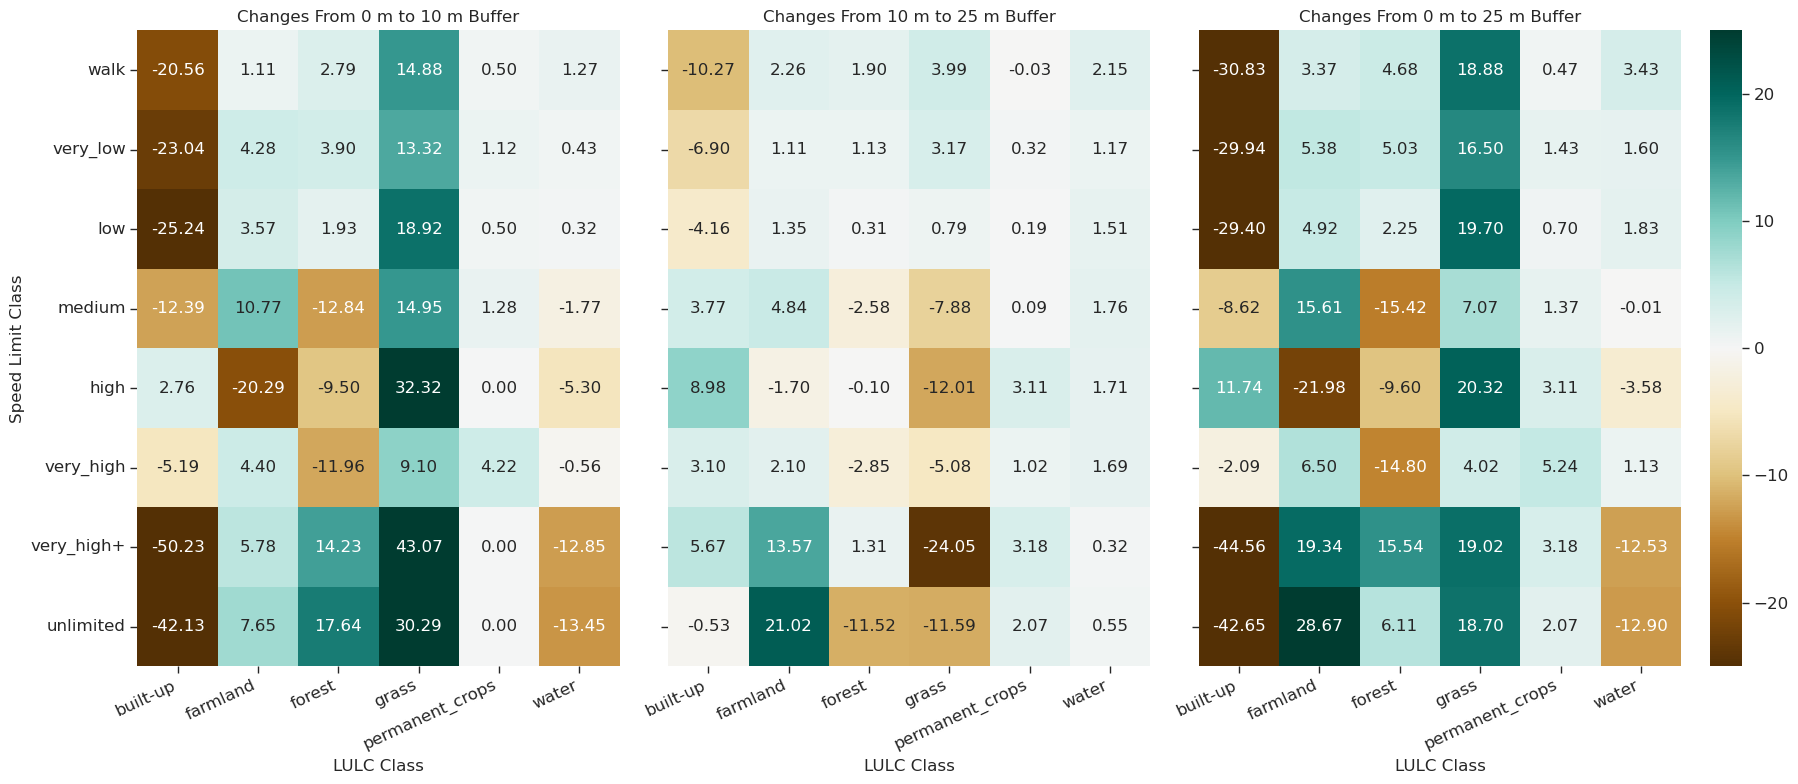

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(18, 8), sharey=True)

vmin=-25
vmax=25

sns.heatmap(diff_0_to_10_speeds, cmap=cmap_diverging, annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar=False, ax=axs[0])
axs[0].set_title('Changes From 0 m to 10 m Buffer')
axs[0].set_ylabel('Speed Limit Class')
axs[0].set_yticklabels(axs[0].get_yticklabels(), rotation=0)
axs[0].set_xlabel('LULC Class')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=25, ha='right')

sns.heatmap(diff_10_to_25_speeds, cmap=cmap_diverging, annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar=False, ax=axs[1])
axs[1].set_title('Changes From 10 m to 25 m Buffer')
axs[1].set_ylabel('')
axs[1].set_xlabel('LULC Class')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=25, ha='right')

sns.heatmap(diff_0_to_25_speeds, cmap=cmap_diverging, annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar_kws={'pad': -0.15, 'anchor': (2.5, 0.5)}, ax=axs[2])
axs[2].set_title('Changes From 0 m to 25 m Buffer')
axs[2].set_ylabel('')
axs[2].set_xlabel('LULC Class')
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=25, ha='right')

# plt.savefig(out_dir / 'speeds_lulc_horizontal_changes.png', dpi=150, bbox_inches='tight')

plt.tight_layout()
plt.show()

Correlation Analysis between LULC classes (because based on speed limit classes)

In [36]:
# Calculate p-values of according correlation coefficient
def compute_p_values(df):
    # Initialize an empty DataFrame with the same columns and indices as the input
    p_values = pd.DataFrame(index=df.columns, columns=df.columns)
    # Iterate over all pairs of columns
    for col1 in df.columns:
        for col2 in df.columns:
            # Compute the Pearson correlation and p-value
            _, p_value = pearsonr(df[col1], df[col2])
            # Assign the p-value to the corresponding cell in the output DataFrame
            p_values.loc[col1, col2] = p_value
    return p_values

In [37]:
# Categorize p-values and add as annotations to heatmap
def format_corr_with_pval(correlation_matrix, p_values_matrix):
    # Initialize an empty matrix with the same shape as the correlation matrix
    formatted_matrix = correlation_matrix.astype(str)
    # Iterate over the matrix elements
    for row in range(correlation_matrix.shape[0]):
        for col in range(correlation_matrix.shape[1]):
            value = correlation_matrix.iloc[row, col]
            p_value = p_values_matrix.iloc[row, col]
            # Check if comparing the same class (self-class correlation)
            if row == col:
                asterisks = ''  # No asterisks for self-class correlation
            else:
                # Determine the number of asterisks based on the p-value
                if p_value < 0.001:
                    asterisks = '***'
                elif p_value < 0.01:
                    asterisks = '**'
                elif p_value < 0.05:
                    asterisks = '*'
                else:
                    asterisks = ''
            # Format the string with the value and asterisks
            formatted_matrix.iloc[row, col] = f'{value:.2f}{asterisks}'
    return formatted_matrix

Pearson Correlation Analysis

In [38]:
correlation_matrix_speeds = lulc_pivot_percent_speeds.corr(method='pearson')
correlation_matrix_speeds_10 = lulc_pivot_percent_speeds_10.corr(method='pearson')
correlation_matrix_speeds_25 = lulc_pivot_percent_speeds_25.corr(method='pearson')

correlation_matrix_speeds_mean = lulc_pivot_percent_speeds_mean.corr(method='pearson')

In [39]:
p_values_speeds = compute_p_values(lulc_pivot_percent_speeds)
p_values_speeds_10 = compute_p_values(lulc_pivot_percent_speeds_10)
p_values_speeds_25 = compute_p_values(lulc_pivot_percent_speeds_25)

p_values_speeds_mean = compute_p_values(lulc_pivot_percent_speeds_mean)

In [40]:
p_values_speeds = p_values_speeds.apply(pd.to_numeric)
p_values_speeds_10 = p_values_speeds_10.apply(pd.to_numeric)
p_values_speeds_25 = p_values_speeds_25.apply(pd.to_numeric)

p_values_speeds_mean = p_values_speeds_mean.apply(pd.to_numeric)

formatted_matrix_speeds = format_corr_with_pval(correlation_matrix_speeds, p_values_speeds)
formatted_matrix_speeds_10 = format_corr_with_pval(correlation_matrix_speeds_10, p_values_speeds_10)
formatted_matrix_speeds_25 = format_corr_with_pval(correlation_matrix_speeds_25, p_values_speeds_25)

formatted_matrix_roads_mean = format_corr_with_pval(correlation_matrix_speeds_mean, p_values_speeds_mean)

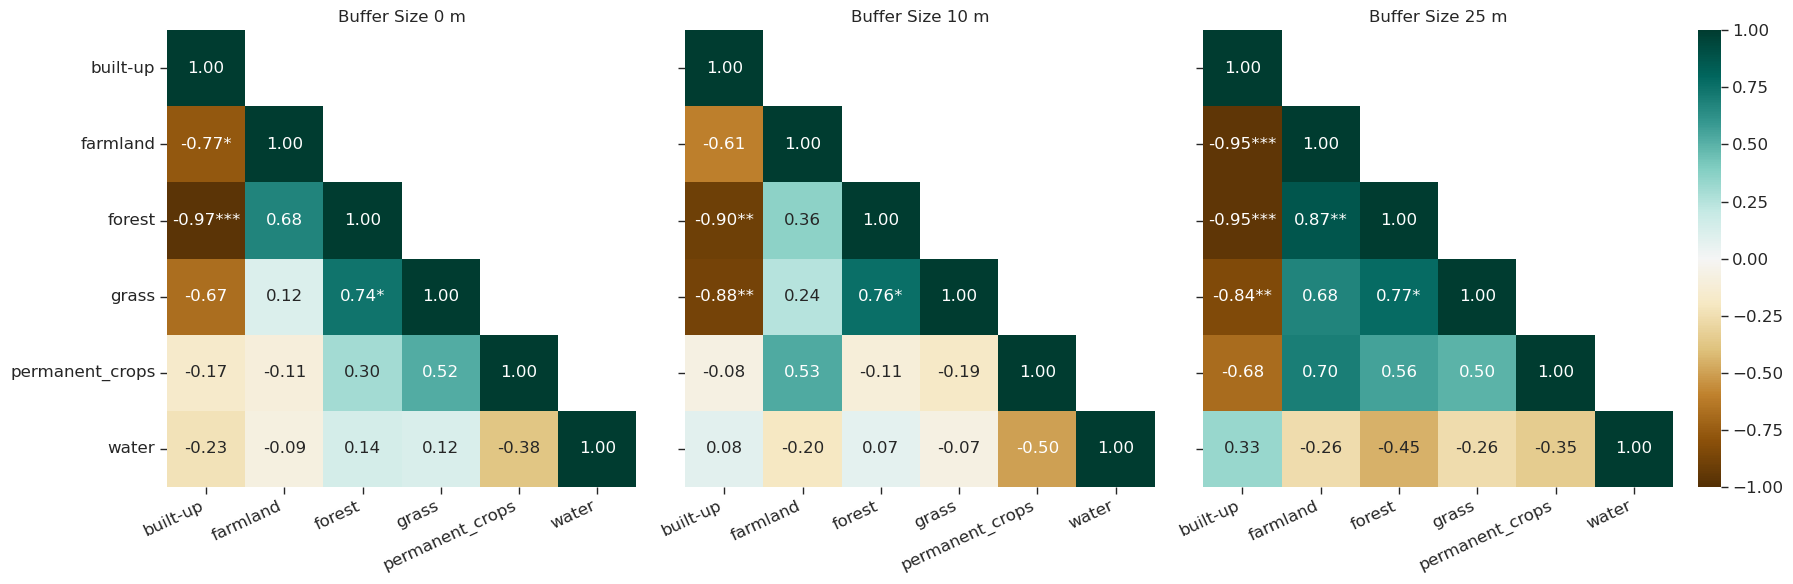

In [41]:
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix_speeds, dtype=bool), k=1)

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

vmin=-1
vmax=1

sns.heatmap(correlation_matrix_speeds, cmap=cmap_diverging, annot=formatted_matrix_speeds, fmt='', vmin=vmin, vmax=vmax, mask=mask, cbar=False, ax=axs[0])
axs[0].set_title('Buffer Size 0 m')
axs[0].set_ylabel('')
axs[0].set_xlabel('')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=25, ha='right')

sns.heatmap(correlation_matrix_speeds_10, cmap=cmap_diverging, annot=formatted_matrix_speeds_10, fmt='', vmin=vmin, vmax=vmax, mask=mask, cbar=False, ax=axs[1])
axs[1].set_title('Buffer Size 10 m')
axs[1].set_ylabel('')
axs[1].set_xlabel('')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=25, ha='right')

sns.heatmap(correlation_matrix_speeds_25, cmap=cmap_diverging, annot=formatted_matrix_speeds_25, fmt='', vmin=vmin, vmax=vmax, mask=mask, cbar_kws={'pad': -0.15, 'anchor': (2, 0.5)}, ax=axs[2])
axs[2].set_title('Buffer Size 25 m')
axs[2].set_ylabel('')
axs[2].set_xlabel('')
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=25, ha='right')

# plt.savefig(out_dir / 'speeds_lulc_correlation.png', dpi=150, bbox_inches='tight')

plt.tight_layout()
plt.show()

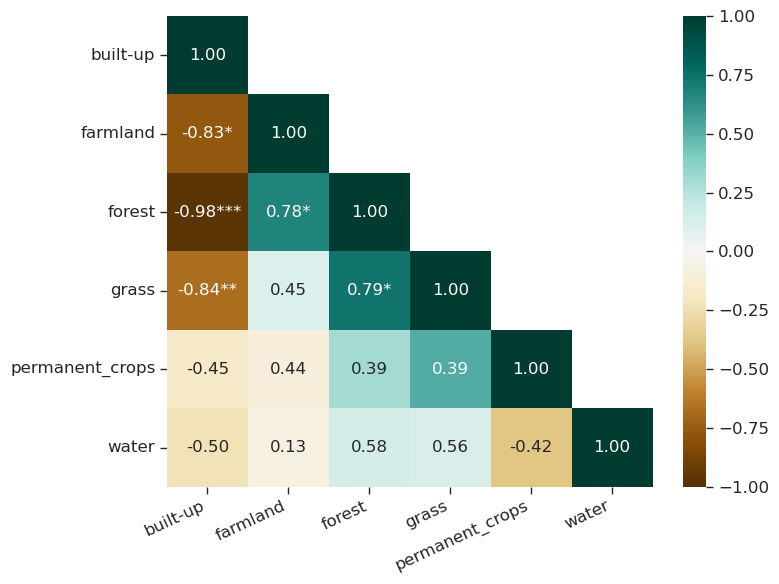

In [42]:
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix_speeds, dtype=bool), k=1)

fig, ax = plt.subplots(figsize=(8, 6))

vmin=-1
vmax=1

sns.heatmap(correlation_matrix_speeds, cmap=cmap_diverging, annot=formatted_matrix_roads_mean, fmt='', vmin=vmin, vmax=vmax, mask=mask, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')

# plt.savefig(out_dir / 'road_types_lulc_correlation.png', dpi=150, bbox_inches='tight')

plt.tight_layout()
plt.show()

Hierachical Clustering Analysis

In [51]:
speed_cluster = linkage(lulc_pivot_percent_speeds, method='ward', optimal_ordering=True)
speed_cluster_10 = linkage(lulc_pivot_percent_speeds_10, method='ward', optimal_ordering=True)
speed_cluster_25 = linkage(lulc_pivot_percent_speeds_25, method='ward', optimal_ordering=True)

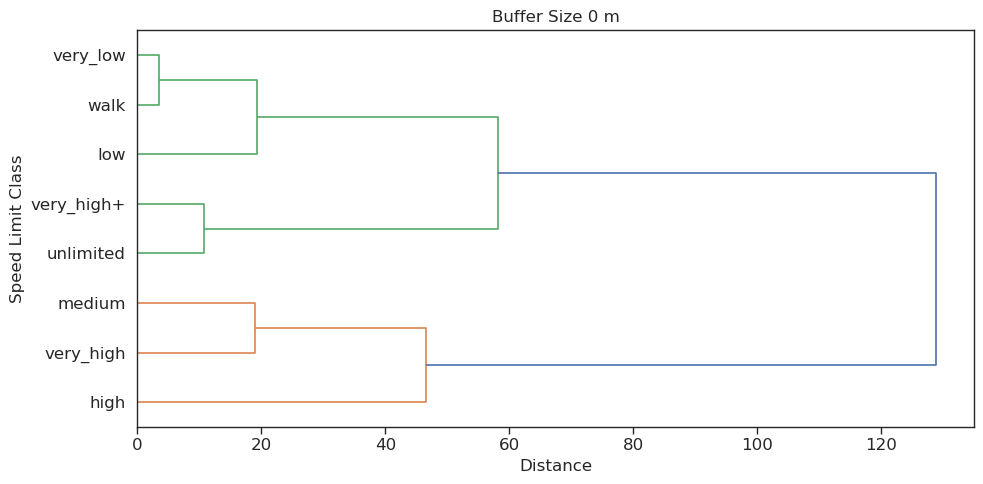

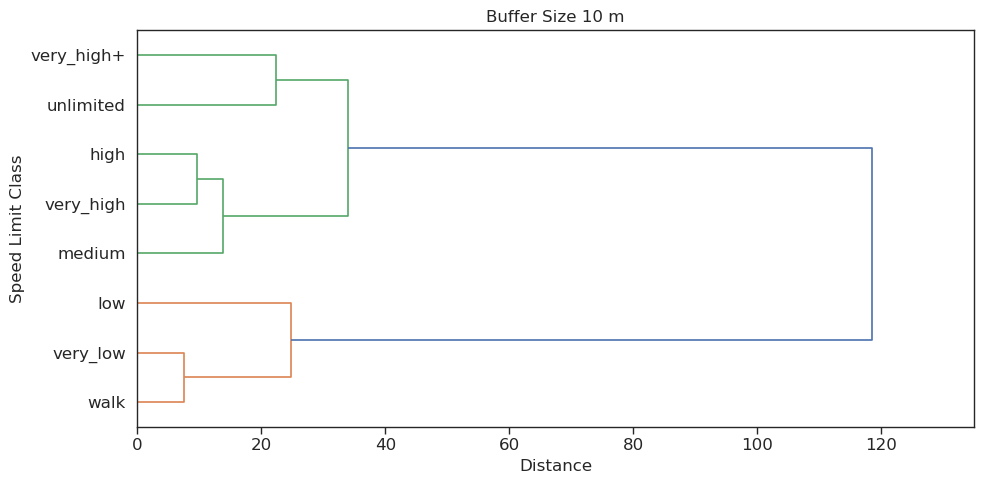

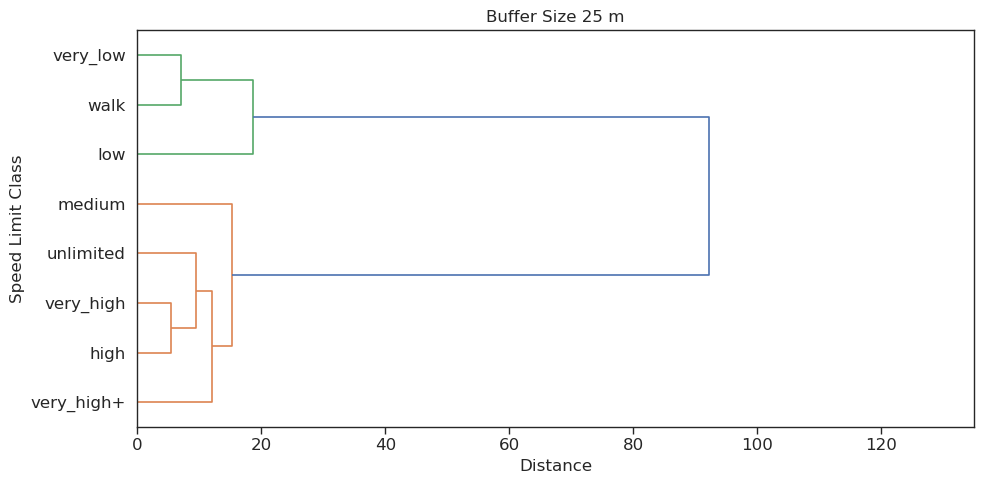

In [60]:
xmax = 135

# Dendrogram for lulc_pivot_percent_speeds
fig, ax = plt.subplots(figsize=(10, 5))
dendrogram(speed_cluster, labels=lulc_pivot_percent_speeds.index, orientation='right', leaf_font_size=12, ax=ax)
ax.set_title('Buffer Size 0 m')
ax.set_xlabel('Distance')
ax.set_ylabel('Speed Limit Class')
ax.set_xlim(0, xmax)
plt.tight_layout()
plt.show()

# Dendrogram for lulc_pivot_percent_speeds_10
fig, ax = plt.subplots(figsize=(10, 5))
dendrogram(speed_cluster_10, labels=lulc_pivot_percent_speeds_10.index, orientation='right', leaf_font_size=12, ax=ax)
ax.set_title('Buffer Size 10 m')
ax.set_xlabel('Distance')
ax.set_ylabel('Speed Limit Class')
ax.set_xlim(0, xmax)
plt.tight_layout()
plt.show()

# Dendrogram for lulc_pivot_percent_speeds_25
fig, ax = plt.subplots(figsize=(10, 5))
dendrogram(speed_cluster_25, labels=lulc_pivot_percent_speeds_25.index, orientation='right', leaf_font_size=12, ax=ax)
ax.set_title('Buffer Size 25 m')
ax.set_xlabel('Distance')
ax.set_ylabel('Speed Limit Class')
ax.set_xlim(0, xmax)
plt.tight_layout()
plt.show()

Mean Hierarchical Clustering Analysis

In [55]:
lulc_pivot_percent_speeds_mean = (lulc_pivot_percent_speeds + lulc_pivot_percent_speeds_10 + lulc_pivot_percent_speeds_25) / 3
cluster = linkage(lulc_pivot_percent_speeds_mean, method='ward', optimal_ordering=True)

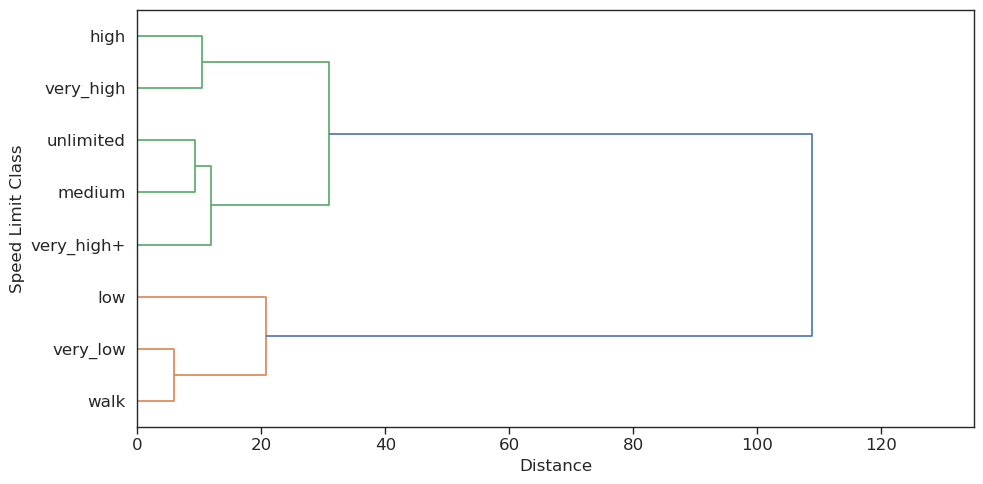

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Dendrogram for lulc_pivot_percent_roads
dendrogram(cluster, labels=lulc_pivot_percent_speeds_mean.index, orientation='right', leaf_font_size=12, ax=ax)
ax.set_xlabel('Distance')
ax.set_ylabel('Speed Limit Class')
ax.set_xlim(0, xmax)

plt.tight_layout()
plt.show()

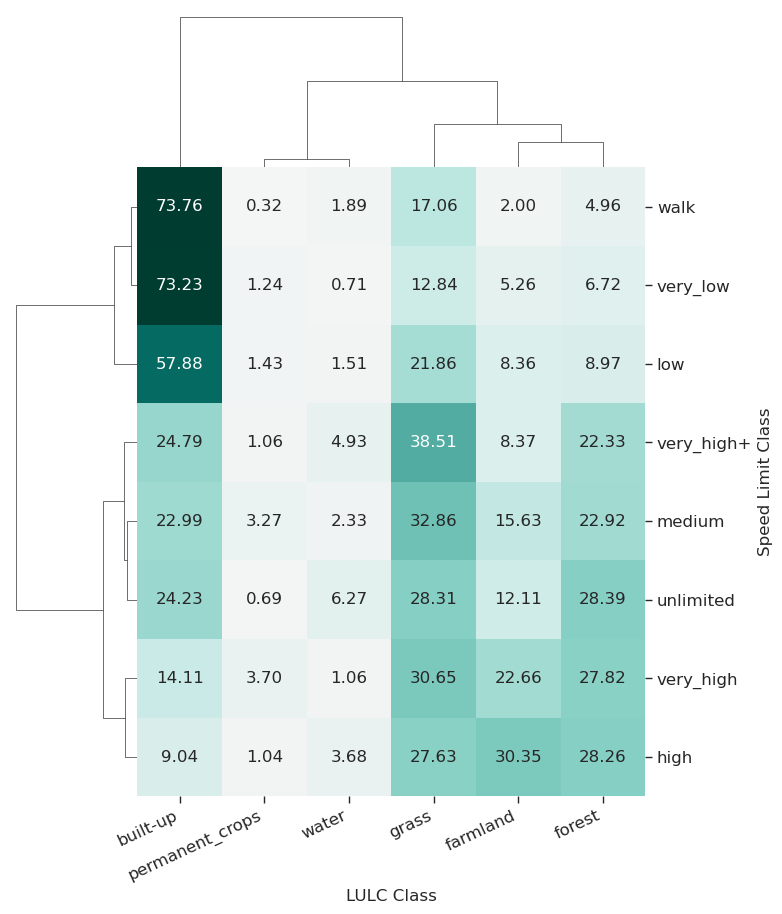

In [63]:
g = sns.clustermap(lulc_pivot_percent_speeds_mean, figsize=(8, 10), method='ward', cmap=cmap_sequential,
                   col_cluster=True, row_linkage=cluster, annot=True, fmt='.2f', cbar_pos=None)

g.ax_heatmap.set_xlabel('LULC Class')
g.ax_heatmap.set_ylabel('Speed Limit Class')
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=25, ha='right')

plt.show()